<a href="https://colab.research.google.com/github/JimKing100/nfl-test/blob/master/Prediction_Defense1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

In [0]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from sklearn import preprocessing

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [0]:
# Import data
original_df = pd.read_csv('https://raw.githubusercontent.com/JimKing100/nfl-test/master/data-actuals/actuals_defense.csv')

In [4]:
original_df.head()

,player,first,last,name,position1,2000-game1,2000-game2,2000-game3,2000-game4,2000-game5,2000-game6,2000-game7,2000-game8,2000-game9,2000-game10,2000-game11,2000-game12,2000-game13,2000-game14,2000-game15,2000-game16,2001-game1,2001-game2,2001-game3,2001-game4,2001-game5,2001-game6,2001-game7,2001-game8,2001-game9,2001-game10,2001-game11,2001-game12,2001-game13,2001-game14,2001-game15,2001-game16,2002-game1,2002-game2,2002-game3,...,2017-game9,2017-game10,2017-game11,2017-game12,2017-game13,2017-game14,2017-game15,2017-game16,2018-game1,2018-game2,2018-game3,2018-game4,2018-game5,2018-game6,2018-game7,2018-game8,2018-game9,2018-game10,2018-game11,2018-game12,2018-game13,2018-game14,2018-game15,2018-game16,2019-game1,2019-game2,2019-game3,2019-game4,2019-game5,2019-game6,2019-game7,2019-game8,2019-game9,2019-game10,2019-game11,2019-game12,2019-game13,2019-game14,2019-game15,2019-game16
0,SF,San Francisco,49ers,San Francisco 49ers,DF,-1.0,1.0,2.0,9.0,2.0,4.0,1.0,2.0,3.0,3.0,8.0,16.0,19.0,4.0,8.0,1.0,5.0,6.0,5.0,8.0,3.0,15.0,6.0,3.0,0.0,17.0,14.0,8.0,20.0,9.0,3.0,17.0,12.0,6.0,12.0,...,4,5,2,3,6,3,12,10,7.0,4.0,-1.0,8.0,0.0,2.0,-1.0,9.0,11.0,1.0,1.0,0.0,3.0,3.0,8.0,-5.0,24,7,6,14,9,9,16,3,19,14,10,3,-3,1,7,1
1,CHI,Chicago,Bears,Chicago Bears,DF,2.0,-1.0,9.0,7.0,8.0,9.0,4.0,8.0,12.0,3.0,19.0,3.0,0.0,3.0,8.0,15.0,5.0,10.0,26.0,14.0,8.0,14.0,11.0,5.0,10.0,9.0,10.0,5.0,13.0,11.0,26.0,15.0,7.0,11.0,6.0,...,3,5,4,5,10,6,11,8,14.0,17.0,13.0,13.0,5.0,2.0,4.0,27.0,12.0,14.0,13.0,4.0,17.0,8.0,6.0,7.0,8,5,21,14,4,-2,4,4,7,5,4,4,2,1,1,8
2,CIN,Cincinnati,Bengals,Cincinnati Bengals,DF,3.0,9.0,-1.0,5.0,12.0,2.0,8.0,8.0,1.0,2.0,4.0,3.0,8.0,1.0,4.0,11.0,5.0,23.0,1.0,7.0,5.0,2.0,10.0,2.0,5.0,9.0,9.0,13.0,1.0,8.0,20.0,7.0,0.0,1.0,0.0,...,6,10,5,3,1,3,7,9,12.0,12.0,0.0,0.0,22.0,-1.0,1.0,19.0,-5.0,4.0,-3.0,4.0,2.0,10.0,2.0,10.0,6,-1,5,2,1,9,2,0,-2,8,6,8,5,1,1,12
3,BUF,Buffalo,Bills,Buffalo Bills,DF,9.0,8.0,2.0,3.0,3.0,10.0,1.0,15.0,10.0,20.0,12.0,6.0,3.0,-1.0,4.0,13.0,2.0,10.0,2.0,-3.0,11.0,1.0,11.0,13.0,0.0,3.0,1.0,10.0,12.0,10.0,7.0,2.0,2.0,14.0,3.0,...,-3,-4,7,5,4,9,7,4,-1.0,1.0,14.0,6.0,11.0,15.0,-3.0,2.0,0.0,10.0,7.0,5.0,2.0,3.0,7.0,13.0,7,6,11,3,10,11,4,7,4,9,10,11,3,17,2,7
4,DEN,Denver,Broncos,Denver Broncos,DF,11.0,13.0,18.0,13.0,10.0,13.0,22.0,3.0,6.0,18.0,8.0,12.0,9.0,14.0,10.0,13.0,5.0,10.0,2.0,16.0,9.0,7.0,18.0,-1.0,12.0,10.0,6.0,2.0,12.0,11.0,10.0,2.0,8.0,7.0,12.0,...,-2,4,4,11,11,4,4,12,12.0,3.0,6.0,1.0,4.0,7.0,31.0,3.0,4.0,7.0,11.0,13.0,7.0,7.0,1.0,6.0,0,1,0,7,11,17,0,7,2,7,3,7,15,5,5,5


In [5]:
player = original_df['player'].iloc[1]
player

'CHI'

In [6]:
train_data = original_df.iloc[1, 5:309]
train_data

2000-game1      2
2000-game2     -1
2000-game3      9
2000-game4      7
2000-game5      8
               ..
2018-game12     4
2018-game13    17
2018-game14     8
2018-game15     6
2018-game16     7
Name: 1, Length: 304, dtype: object

In [7]:
model = pm.auto_arima(train_data, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1982.774, BIC=1997.642, Time=0.449 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1992.064, BIC=1999.498, Time=0.016 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1990.874, BIC=2002.025, Time=0.092 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1991.038, BIC=2002.189, Time=0.110 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=2288.351, BIC=2292.068, Time=0.009 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=1984.734, BIC=2003.319, Time=0.598 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1984.724, BIC=2003.309, Time=0.597 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1992.946, BIC=2007.814, Time=0.144 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=1992.474, BIC=2007.342, Time=0.164 seconds
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=1986.456, BIC=2008.

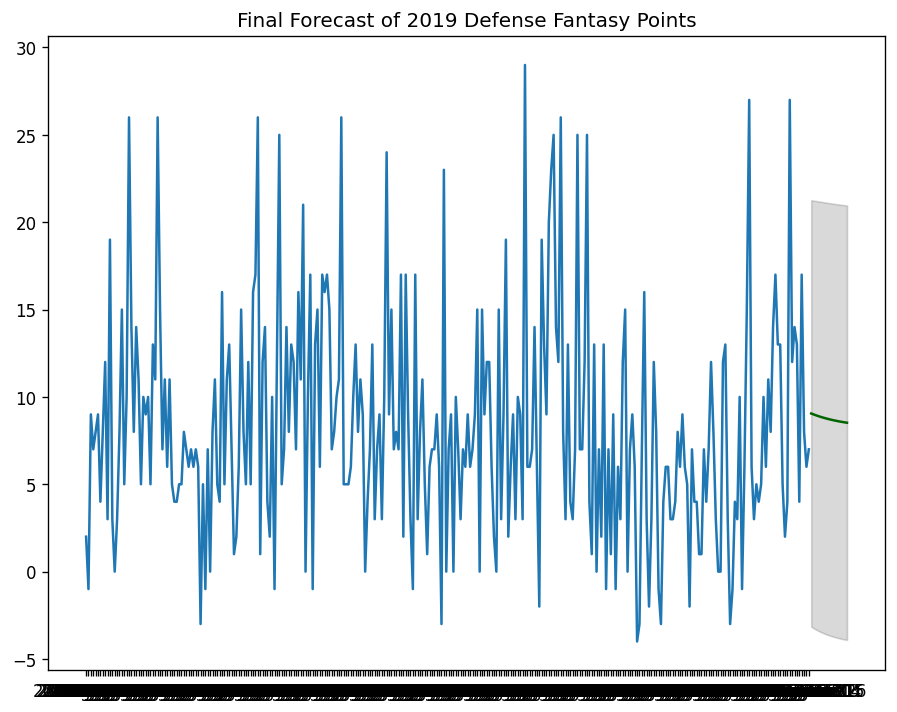

In [8]:
# Forecast
n_periods = 16
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(train_data), len(train_data)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train_data)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of 2019 Defense Fantasy Points")
plt.show()

In [9]:
fc_series

304    9.051353
305    8.997700
306    8.947466
307    8.900433
308    8.856397
309    8.815167
310    8.776564
311    8.740421
312    8.706581
313    8.674898
314    8.645233
315    8.617458
316    8.591454
317    8.567106
318    8.544310
319    8.522966
dtype: float64

In [10]:
fc_series.sum()

139.9555107878528

In [11]:
fc = fc_series.to_frame()
fc = fc.reset_index(drop=True)
fc = fc.rename(columns = {0:'forecast'})
fc

,forecast
0,9.051353
1,8.997700
2,8.947466
3,8.900433
4,8.856397
5,8.815167
6,8.776564
7,8.740421
8,8.706581
9,8.674898


In [12]:
data = {'spread': [3, 2.5, 4, 2, 5, 4, 3.5, -4, 2.5, -6, 6, 5.5, -3, -4.5, -6, 3]}
df = pd.DataFrame(data)
df

,spread
0,3.0
1,2.5
2,4.0
3,2.0
4,5.0
5,4.0
6,3.5
7,-4.0
8,2.5
9,-6.0


In [13]:
# Create x, where x the 'scores' column's values as floats
x = df[['spread']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)

df_normalized = df_normalized.rename(columns = {0:'spread'})
df_normalized

,spread
0,0.750000
1,0.708333
2,0.833333
3,0.666667
4,0.916667
5,0.833333
6,0.791667
7,0.166667
8,0.708333
9,0.000000


In [14]:
result = pd.concat([fc, df_normalized], axis=1)
result

,forecast,spread
0,9.051353,0.750000
1,8.997700,0.708333
2,8.947466,0.833333
3,8.900433,0.666667
4,8.856397,0.916667
5,8.815167,0.833333
6,8.776564,0.791667
7,8.740421,0.166667
8,8.706581,0.708333
9,8.674898,0.000000


In [0]:
result['final'] = result['forecast'] * result['spread']

In [16]:
result

,forecast,spread,final
0,9.051353,0.750000,6.788515
1,8.997700,0.708333,6.373371
2,8.947466,0.833333,7.456222
3,8.900433,0.666667,5.933622
4,8.856397,0.916667,8.118364
5,8.815167,0.833333,7.345973
6,8.776564,0.791667,6.948114
7,8.740421,0.166667,1.456737
8,8.706581,0.708333,6.167162
9,8.674898,0.000000,0.000000
